# Submission 2. Fast-ai

| Variable | Definition                      | Key                                         |
|----------|---------------------------------|---------------------------------------------|
| survival | Survival                        | 0 = No, 1 = Yes                             |
| pclass   | Ticket class                    | 1 = 1st, 2 = 2nd, 3 = 3rd                   |
| sex      | Sex                             |                                             |
| Age      | Age in years                    |                                             |
| sibsp    | # of siblings / spouses aboard the Titanic |                               |
| parch    | # of parents / children aboard the Titanic  |                               |
| ticket   | Ticket number                   |                                             |
| fare     | Passenger fare                  |                                             |
| cabin    | Cabin number                    |                                             |
| embarked | Port of Embarkation             | C = Cherbourg, Q = Queenstown, S = Southampton |

In [1]:
import pandas as pd
from pathlib import Path
import os
from fastai.tabular.all import *

In [2]:
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    path = Path('../input/titanic')
    !pip install -Uqq fastai
else:
    import zipfile,kaggle
    path = Path('titanic')
    if not path.exists():
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

In [3]:
pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

In [4]:
# Read train and test files into pandas dataframes
df = pd.read_csv('train.csv')
df_submission = pd.read_csv('test.csv')

# Preprocessing


Feature Engineering

In [5]:
def add_features(df):
    df['LogFare'] = np.log1p(df['Fare'])
    df['Deck'] = df.Cabin.str[0].map(dict(A="ABC",B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG"))
    df['Family'] = df.SibSp+df.Parch
    df['Alone'] = df.Family==0
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    df['Title'] = df.Title.map(dict(Mr="Mr",Miss="Miss",Mrs="Mrs",Master="Master"))

add_features(df)

# Modeling

Prepare Dataloader

In [6]:
# Create splits
splits = RandomSplitter(seed=42)(df)

In [7]:
# Create DataLoader
dls = TabularPandas(
    df, splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=["Sex","Pclass","Embarked","Deck", "Title"],
    cont_names=['Age', 'SibSp', 'Parch', 'LogFare',
                 'Alone', 'TicketFreq', 'Family'],
    y_names="Survived", y_block = CategoryBlock(),
).dataloaders(path=".")

Model Building

In [82]:
# Create learner. Size of each hidden layer ([10,10])
learn = tabular_learner(dls, layers=[10,10], metrics=accuracy)

SuggestedLRs(slide=0.0691830962896347, valley=5.248074739938602e-05)

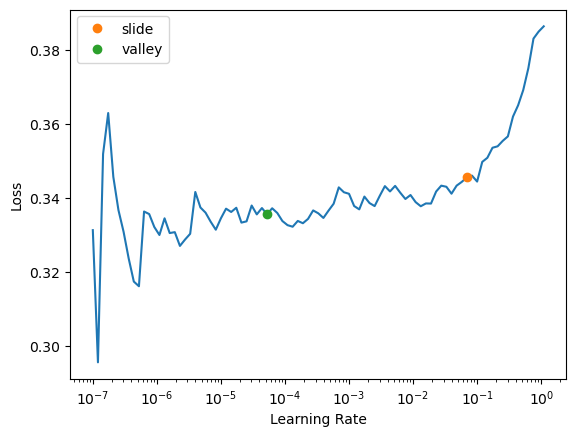

In [80]:
# Finding google learning rate
learn.lr_find(suggest_funcs=(slide, valley))

# Train the model

In [83]:
learn.fit(16, lr=0.03)

epoch,train_loss,valid_loss,accuracy,time
0,0.574012,0.580790,0.651685,00:00
1,0.502188,0.450871,0.808989,00:00
2,0.466585,0.418709,0.820225,00:00
3,0.442277,0.434097,0.825843,00:00
4,0.427639,0.439801,0.814607,00:00
5,0.417775,0.422664,0.814607,00:00
6,0.411600,0.414990,0.814607,00:00
7,0.409372,0.433916,0.808989,00:00
8,0.401709,0.424250,0.825843,00:00
9,0.392712,0.430018,0.825843,00:00


# Save model

In [16]:
learn.export('./models/fastai_tabular')
del learn

# Load Model

In [17]:
learn=load_learner('./models/fastai_tabular')

# Submit to Kaggle

Prepare the data

In [107]:
def submit_to_kaggle(path_submission_csv_read, learn,name_final_submission_csv_write,message):
    df_submission = pd.read_csv(path_submission_csv_read) # Read test file
    df_submission['Fare'] = df_submission.Fare.fillna(0)# There is one Fare missing
    add_features(df_submission) # Add features to test dataframe
    dl = learn.dls.test_dl(df_submission) # Create DataLoader for test dataframe from the configurations of the learner
    preds,_ = learn.get_preds(dl=dl) # Get predictions
    df_submission['Survived'] = (preds[:,1]>0.5).int() # Add predictions to dataframe
    df_submission = df_submission[['PassengerId','Survived']] # Create submission dataframe
    df_submission.to_csv(name_final_submission_csv_write, index=False) # Save submission dataframe to csv file
    os.system("kaggle competitions submit -c titanic -f "+name_final_submission_csv_write+" -m "+f"\"message\"")

In [20]:
df_submission = pd.read_csv(path/'test.csv') # Read test file
df_submission['Fare'] = df_submission.Fare.fillna(0)# There is one Fare missing
add_features(df_submission) # Add features to test dataframe
dl_test = learn.dls.test_dl(df_submission) # Create DataLoader for test dataframe from the configurations of the learner

Get predictions

In [21]:
preds,_=learn.get_preds(dl=dl_test) # Get predictions

Create submission file

In [22]:
df_submission['Survived'] = (preds[:,1]>0.5).int() # Add predictions to dataframe
sub_df_submission = df_submission[['PassengerId','Survived']] # Create submission dataframe
sub_df_submission.to_csv('sub2.csv', index=False) # Save submission dataframe to csv file

In [23]:
!head sub.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,1
897,0
898,0
899,0
900,1


In [24]:
# !kaggle competitions submit -c titanic -f sub2.csv -m "Fastai Tabular Learner with 10,10 layers. 16 epochs. 0.03 learning rate. 0.5 threshold."

100%|██████████████████████████████████████| 2.77k/2.77k [00:00<00:00, 3.97kB/s]
Successfully submitted to Titanic - Machine Learning from Disaster

# Permutation Importance. NOT WORKING

In [18]:
class PermutationImportance():
  "Calculate and plot the permutation importance"
  def __init__(self, learn:Learner, df=None, bs=None):
    "Initialize with a test dataframe, a learner, and a metric"
    self.learn = learn
    self.df = df if df is not None else None
    bs = bs if bs is not None else learn.dls.bs
    self.dl = learn.dls.test_dl(self.df, bs=bs) if self.df is not None else learn.dls[1]
    self.x_names = learn.dls.x_names.filter(lambda x: '_na' not in x)
    self.na = learn.dls.x_names.filter(lambda x: '_na' in x)
    self.y = dls.y_names
    self.results = self.calc_feat_importance()
    self.plot_importance(self.ord_dic_to_df(self.results))

  def measure_col(self, name:str):
    "Measures change after column shuffle"
    col = [name]
    if f'{name}_na' in self.na: col.append(name)
    orig = self.dl.items[col].values
    perm = np.random.permutation(len(orig))
    self.dl.items[col] = self.dl.items[col].values[perm]
    metric = learn.validate(dl=self.dl)[1]
    self.dl.items[col] = orig
    return metric

  def calc_feat_importance(self):
    "Calculates permutation importance by shuffling a column on a percentage scale"
    print('Getting base error')
    base_error = self.learn.validate(dl=self.dl)[1]
    self.importance = {}
    pbar = progress_bar(self.x_names)
    print('Calculating Permutation Importance')
    for col in pbar:
      self.importance[col] = self.measure_col(col)
    for key, value in self.importance.items():
      self.importance[key] = (base_error-value)/base_error #this can be adjusted
    return OrderedDict(sorted(self.importance.items(), key=lambda kv: kv[1], reverse=True))

  def ord_dic_to_df(self, dict:OrderedDict):
    return pd.DataFrame([[k, v] for k, v in dict.items()], columns=['feature', 'importance'])

  def plot_importance(self, df:pd.DataFrame, limit=20, asc=False, **kwargs):
    "Plot importance with an optional limit to how many variables shown"
    df_copy = df.copy()
    df_copy['feature'] = df_copy['feature'].str.slice(0,25)
    df_copy = df_copy.sort_values(by='importance', ascending=asc)[:limit].sort_values(by='importance', ascending=not(asc))
    ax = df_copy.plot.barh(x='feature', y='importance', sort_columns=True, **kwargs)
    for p in ax.patches:
      ax.annotate(f'{p.get_width():.4f}', ((p.get_width() * 1.005), p.get_y()  * 1.005))

# Bayesian Optimization

In [24]:
from bayes_opt import BayesianOptimization

In [20]:
def fit_with(lr:float, wd:float, dp:float, n_layers:float, layer_1:float, layer_2:float, layer_3:float):

    print(lr, wd, dp)
    if round(n_layers) == 2:
        layers = [round(layer_1), round(layer_2)]
    elif int(n_layers) == 3:
        layers = [round(layer_1), round(layer_2), round(layer_3)]
    else:
        layers = [round(layer_1)]
    config = tabular_config(embed_p=float(dp),ps=float(wd))
    learn = tabular_learner(dls, layers=layers, metrics=accuracy, config = config)

    with learn.no_bar() and learn.no_logging():
        learn.fit(5, lr=float(lr))

    acc = float(learn.validate()[1])

    return acc

In [36]:
hps = {'lr': (1e-05, 1e-01),
      'wd': (4e-4, 0.4),
      'dp': (0.01, 0.5),
       'n_layers': (1,3),
       'layer_1': (5, 200),
       'layer_2': (5, 1000),
       'layer_3': (5, 2000)}

In [37]:
optim = BayesianOptimization(
    f = fit_with, # our fit function
    pbounds = hps, # our hyper parameters to tune
    verbose = 2, # 1 prints out when a maximum is observed, 0 for silent
    random_state=1
)

In [38]:
%time optim.maximize(n_iter=10)

|   iter    |  target   |    dp     |  layer_1  |  layer_2  |  layer_3  |    lr     | n_layers  |    wd     |
-------------------------------------------------------------------------------------------------------------
0.014684121522803134 0.07482958046651729 0.21434078230426126


| 1         | 0.8034    | 0.2143    | 145.5     | 5.114     | 608.2     | 0.01468   | 1.185     | 0.07483   |
0.06852509784467198 0.3512957275818218 0.1793247562510934


| 2         | 0.8202    | 0.1793    | 82.37     | 541.1     | 841.3     | 0.06853   | 1.409     | 0.3513    |
0.014047289990137426 0.32037752964274446 0.02341992066698382


| 3         | 0.7921    | 0.02342   | 135.7     | 420.2     | 1.12e+03  | 0.01405   | 1.396     | 0.3204    |
0.0894617202837497 0.016006291379859792 0.4844481721025048


| 4         | 0.8202    | 0.4844    | 66.12     | 693.9     | 1.753e+03 | 0.08946   | 1.17      | 0.01601   |
0.0957893741197487 0.27687409473460917 0.09321690558663875


| 5         | 0.8315    | 0.09322   | 176.2     | 102.9     | 845.1     | 0.09579   | 2.066     | 0.2769    |
0.045611501469886975 0.16956747930476096 0.2825931826136739


| 6         | 0.8315    | 0.2826    | 174.6     | 104.6     | 835.5     | 0.04561   | 2.867     | 0.1696    |
0.09042647653384613 0.12538277802832737 0.41685967505779203


| 7         | 0.809     | 0.4169    | 17.05     | 84.15     | 901.7     | 0.09043   | 2.901     | 0.1254    |
0.08628136340843401 0.09782266759025895 0.49773898025590213


| 8         | 0.809     | 0.4977    | 195.9     | 229.5     | 824.6     | 0.08628   | 2.443     | 0.09782   |
0.08073260517860165 0.17873127599619254 0.49608039299289214


| 9         | 0.8371    | 0.4961    | 191.1     | 13.03     | 841.0     | 0.08073   | 1.5       | 0.1787    |
0.00988987782166121 0.39854257938214893 0.02096242004890144


| 10        | 0.8315    | 0.02096   | 199.7     | 19.42     | 1.001e+03 | 0.00989   | 2.232     | 0.3985    |
0.06847359315084067 0.02946759766891987 0.13636951025016406


| 11        | 0.8146    | 0.1364    | 158.7     | 6.386     | 1.218e+03 | 0.06847   | 1.324     | 0.02947   |
0.08108510730594247 0.1727224864207598 0.29865916117199437


| 12        | 0.8315    | 0.2987    | 8.943     | 746.6     | 682.6     | 0.08109   | 2.927     | 0.1727    |
0.03144067968503287 0.24159355137237146 0.26933161893875257


| 13        | 0.8034    | 0.2693    | 173.3     | 771.7     | 653.0     | 0.03144   | 1.429     | 0.2416    |
0.02367782505690511 0.20027516644991014 0.32167535312212475


| 14        | 0.8258    | 0.3217    | 7.476     | 740.3     | 811.0     | 0.02368   | 1.222     | 0.2003    |
0.029290966962890352 0.39983341422984864 0.11585129724587008


| 15        | 0.8315    | 0.1159    | 9.007     | 613.5     | 665.6     | 0.02929   | 2.962     | 0.3998    |
CPU times: user 22 s, sys: 4.31 s, total: 26.3 s
Wall time: 20.6 s


In [39]:
print(optim.max)

{'target': 0.8370786309242249, 'params': {'dp': 0.49608039299289214, 'layer_1': 191.09395352053787, 'layer_2': 13.029369744457982, 'layer_3': 841.0009073092418, 'lr': 0.08073260517860165, 'n_layers': 1.5001307819122756, 'wd': 0.17873127599619254}}


In [94]:
dp=float(optim.max['params']['dp'])
wd=float(optim.max['params']['wd'])
lr=float(round(optim.max['params']['lr'],3))
n_layers = int(np.floor(optim.max['params']['n_layers']))  
layers=[int(np.floor(optim.max['params'][f'layer_{i}'])) for i in range(1,n_layers+2)]
print(f'layers:{layers}') 
print(f'lr: {lr}')

layers:[191, 13]
lr: 0.081


In [92]:
config = tabular_config(embed_p=dp,ps=wd)
learn = tabular_learner(dls, layers=layers, metrics=accuracy, config = config)
# learn = tabular_learner(dls, layers=layers, metrics=accuracy)

In [95]:
learn.fit(16, lr=lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.552401,0.514095,0.786517,00:00
1,0.508129,0.490622,0.792135,00:00
2,0.488175,0.425522,0.820225,00:00
3,0.483393,0.421181,0.814607,00:00
4,0.473757,0.433393,0.820225,00:00
5,0.473487,0.443023,0.820225,00:00
6,0.470994,0.402803,0.837079,00:00
7,0.465930,0.426158,0.797753,00:00
8,0.464710,0.404276,0.831461,00:00
9,0.460749,0.396723,0.831461,00:00


In [108]:
# Submit to Kaffle
submit_to_kaggle(path/'test.csv', learn,'submission2_Fastai_Tabular_bayes_opt.csv','Fastai Tabular Learner with Bayes Optimization')

100%|██████████| 2.77k/2.77k [00:00<00:00, 3.84kB/s]


Successfully submitted to Titanic - Machine Learning from Disaster